**Goal:**        
This notebook convert the labels in a way that have the same labels as CheXpert paper [1].


**Refrence:**       
[1] Irvin, Jeremy, et al. "Chexpert: A large chest radiograph dataset with uncertainty labels and expert comparison." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 33. 2019.

In [1]:
# imports
import pandas as pd
import ast
from collections import Counter
from collections import OrderedDict
from itertools import islice
import re
from prettytable import PrettyTable

# Read OpenI dataset

In [2]:
openI_df = pd.read_csv("data/OpenI/OpenI.csv")
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels,NormalLabel
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,['normal'],NaN,1
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,['normal'],NaN,1
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,['normal'],NaN,1
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"['Cardiac Shadow/enlarged/borderline', 'Medias...",NaN,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,['normal'],NaN,1


In [3]:
openI_df = openI_df.drop(['NormalLabel', 'manual_labels'], axis=1)
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,['normal']
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,['normal']
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,['normal']
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"['Cardiac Shadow/enlarged/borderline', 'Medias..."
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,['normal']


In [4]:
# convert str to list
openI_df['expert_labels'] = openI_df.apply(lambda row: ast.literal_eval(row['expert_labels']), axis=1)

In [5]:
type(openI_df['expert_labels'][0])

list

# OpenI labels distribution 


Total No. of Unique labels: 1719


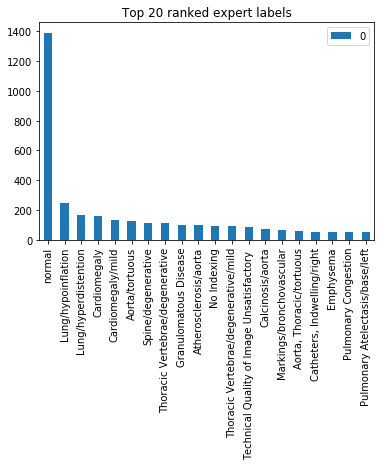

In [6]:
def plot_Barchart_top_n_labels(n=20):
    expert_labels = []
    for labels in openI_df['expert_labels']:
        for label in labels:
            expert_labels.append(label)

    label_counts = Counter(expert_labels)

    sorted_label_counts = OrderedDict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
    
    unique_labels = sorted_label_counts.keys()
    print("Total No. of Unique labels:",len(unique_labels))
    
    sliced = islice(sorted_label_counts.items(), n)  
    sliced_o = OrderedDict(sliced)

    df = pd.DataFrame.from_dict(sliced_o, orient='index')
    df.plot(kind='bar', title = "Top "+str(n)+" ranked expert labels")
    return unique_labels


#********************Original OpenI dataset ****************
unique_labels = plot_Barchart_top_n_labels(20)

# Notes on OpenI Labels 
(From the paper appendix A)
* Code the “normal chest” reports as “Normal” and assign no other codes to these reports

**Vocabulary:**
* Use MeSH as the primary vocabulary and add RadLex terms as needed.

The terms are grouped as follows:
*   Disorder: terms referring to an illness or anomaly of an anatomical part.
*	Objects: terms referring to medical and non-medical foreign bodies.
*	Anatomy: any term that refers to a part of the human body.
*	Signs: imaging observations such as density, opacity or consolidation.
*	Attributes: terms defining characteristics of an object or a disease. 

**ANNOTATION RULES:**    
The codes consist of the headings and subheadings.  The headings are a Disorder, an Anatomical structure, an Object or a Sign.The Sign and Anatomy terms can serve both as the headings and subheadings. The terms are post-coordinated and separated by slashes, similar to MEDLINE indexing.

*	Each code can only include one Disorder, and as many distinct subheadings as included in the report. 
*	An attribute cannot be a heading, and cannot stand alone (with the exception of Image Quality/Unsatisfactory).
*	A Disorder can be followed by an Anatomical site when the name of the disease does not include the affected organ. 
    *	Pneumonia/upper lobe/right (correct)
        *	The anatomical site is included in the disease name: pneumonia
    *	Pneumonia/lung/upper lobe/right (incorrect) 
        *	The term pneumonia refers to lung therefore the lung is not required; it is redundant.
    *	Opacity/lung/base/right (correct)
    *	Opacity/base/right (incorrect)
        *	The term lung is required; neither opacity nor base gives a clear indication of the anatomical location of the finding.
*	When the report contains two or more related terms, use the most specific term. Make sure the more specific term is hierarchically related to the more general term in the controlled vocabulary. 

**Negation:**    
Do not annotate negated terms. In the following examples, tuberculosis and cardiomegaly should not be coded:
*	no signs of tuberculosis in the present study
*	Heart is not significantly enlarged

**Uncertainty:**    
Do not annotate inconclusive findings introduced by the following terms:
*	suggesting
*	favoring
*	concerning for
*	maybe
*	could be
*	possibly
*	and/or
*	may represent
*	presumably
*	considerations may represent
*	differential diagnosis 
*	difficult to exclude
*	cannot exclude 
*	questionable 
*	subtle

**Adverbs of certainty:**     
Annotate terms introduced by adverbs of certainty and their equivalents that indicate presence of a disease or finding. Examples of these triggers include:
*	probably
*	consistent with
*	likely
*	compatible
*	most suggestive



# CheXpert Labels:
* No Finding 
* Enlarged Cardiom. 
* Cardiomegaly 
* Lung Lesion 
* Lung Opacity 
* Edema 
* Consolidation 
* Pneumonia 
* Atelectasis 
* Pneumothorax 
* Pleural Effusion 
* Pleural Other 
* Fracture 
* Support Devices 

# Convert OpenI labels to CheXpert Labels

In [7]:
def find_similar_disorders_caseInsensitive(disorder,unique_labels):
    similar_disorders = []
    for label in unique_labels:
        match = re.search(".*"+disorder+".*", label, flags = re.IGNORECASE)
        if match is not None:
            similar_disorders.append(match.group())
            print(match.group())
    return similar_disorders

def find_similar_disorders_caseSensitive(disorder,unique_labels):
    similar_disorders = []
    for label in unique_labels:
        match = re.search(".*"+disorder+".*", label)
        if match is not None:
            similar_disorders.append(match.group())
            print(match.group())
    return similar_disorders

def update_row(row,similar_disorders,disorder):
#     print("Before:", row)
    new_label_list = []
    for item in row:
        if item in similar_disorders:
            new_label_list.append(disorder)
        else:
            new_label_list.append(item)
#     print("After:",new_label_list)
    return new_label_list

def update_labels(similar_disorders, disorder):
    print("Updating similar labels to :", disorder)
    openI_df['expert_labels'] = openI_df.apply(lambda row: \
                                               update_row(row['expert_labels'],similar_disorders,disorder), \
                                               axis=1)
    
def create_new_column(column_name):
    openI_df[column_name] = openI_df.apply(lambda row: \
                                           1 if column_name in row['expert_labels'] \
                                           else 0, \
                                           axis=1)    

## No Finding
This is the same as normal MeSH Term in OpenI

Updating similar labels to : No Finding
Total No. of Unique labels: 1719


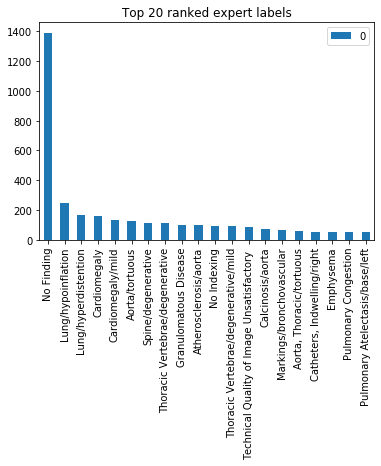

In [8]:
update_labels(['normal'],"No Finding")
unique_labels = plot_Barchart_top_n_labels(20)

In [9]:
create_new_column('No Finding')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1


## Enlarged Cardiom.

In [10]:
disorder = "Cardio"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)

Cardiomegaly
Cardiomegaly/mild
Cardiomegaly/borderline
Cardiomegaly/moderate
Cardiomegaly/severe
Cicatrix/cardiophrenic angle/left/small
Density/cardiophrenic angle/left


## Cardiomegaly

Cardiomegaly
Cardiomegaly/mild
Cardiomegaly/borderline
Cardiomegaly/moderate
Cardiomegaly/severe
Updating similar labels to : Cardiomegaly
Total No. of Unique labels: 1715


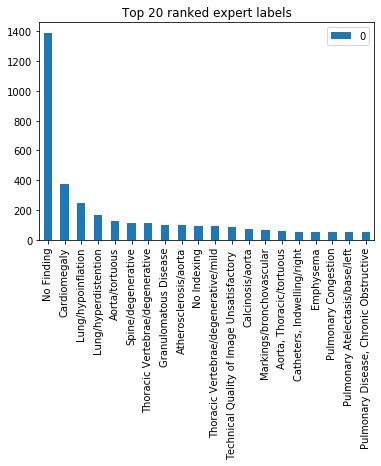

In [11]:
disorder = "Cardiomegaly"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, disorder)
unique_labels = plot_Barchart_top_n_labels(20)

In [12]:
create_new_column('Cardiomegaly')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0


## Lung Lesion

In [13]:
disorder = "lesion"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)

Expansile Bone Lesions/ribs/right


## Lung Opacity

Opacity/lung/base/left
Opacity/lung/base/bilateral
Opacity/lung/middle lobe/right
Opacity/lung/lingula
Opacity/lung/base/right
Opacity/lung/base/bilateral/streaky
Opacity/lung/lower lobe/right
Opacity/lung/base/left/streaky
Opacity/lung/base/bilateral/interstitial
Opacity/lung/bilateral/interstitial/diffuse
Opacity/lung/upper lobe/right
Opacity/lung/right
Opacity/lung/bilateral/interstitial
Opacity/lung/upper lobe/left
Opacity/lung/interstitial
Opacity/lung/base/left/mild
Opacity/lung/base/bilateral/streaky/mild
Opacity/lung/base/left/patchy
Opacity/lung/lower lobe/bilateral
Opacity/lung/apex/right
Opacity/lung/lower lobe/left
Opacity/lung/hilum/right
Opacity/lung/base/right/patchy
Opacity/lung/upper lobe/left/round
Opacity/lung/lower lobe/right/patchy
Opacity/lung/base/bilateral/mild
Opacity/lung
Opacity/lung/hilum/left
Opacity/lung/middle lobe/right/patchy
Opacity/lung/middle lobe/bilateral/interstitial
Opacity/lung/base/bilateral/multiple
Opacity/lung/upper lobe/right/focal
Opacity/

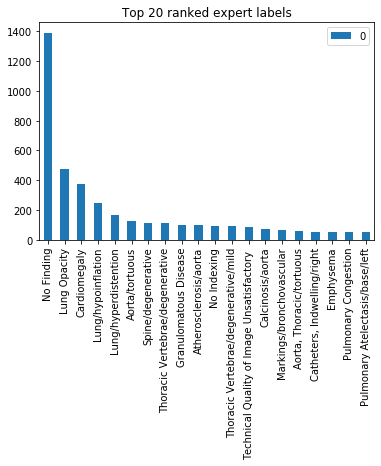

In [14]:
disorder = "Opacity/lung"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, "Lung Opacity")
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [15]:
create_new_column('Lung Opacity')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0


## Edema

Pulmonary Edema
Pulmonary Edema/interstitial
Pulmonary Edema/interstitial/mild
Pulmonary Edema/mild
Pulmonary Edema/lower lobe/bilateral
Pulmonary Edema/base/bilateral/interstitial
Pulmonary Edema/bilateral/interstitial/moderate
Pulmonary Edema/lower lobe/bilateral/interstitial
Pulmonary Edema/bilateral/interstitial/mild
Pulmonary Edema/base/interstitial
Pulmonary Edema/base/bilateral
Pulmonary Edema/pulmonary alveoli
Pulmonary Edema/middle lobe/bilateral
Pulmonary Edema/interstitial/diffuse
Updating similar labels to : Edema

Total No. of Unique labels: 1521


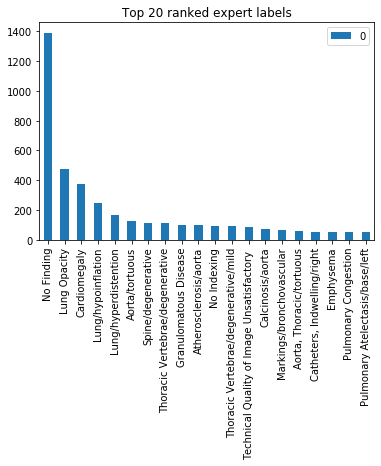

In [16]:
disorder = "Edema"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [17]:
create_new_column('Edema')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0


## Consolidation

Consolidation/lung/lower lobe/left
Consolidation/lung/lower lobe/right
Consolidation/lung/base/right
Consolidation/lung/middle lobe/right
Consolidation/lung/base/left
Consolidation/lung/lower lobe/bilateral
Consolidation/lung/base/bilateral
Consolidation/lung/upper lobe/left
Consolidation/lung
Consolidation/lung/base/left/moderate
Consolidation/lung/multilobar
Consolidation/lung/bilateral
Consolidation/lung/upper lobe/right
Consolidation/lung/lower lobe/right/posterior/focal
Consolidation/lung/upper lobe/right/focal
Consolidation/lung/base/right/mild
Consolidation/lung/hilum/diffuse
Consolidation/pulmonary alveoli
Consolidation/lung/lower lobe/left/retrocardiac
Consolidation/lung/upper lobe/bilateral
Consolidation/lung/lower lobe/left/focal
Updating similar labels to : Consolidation

Total No. of Unique labels: 1501


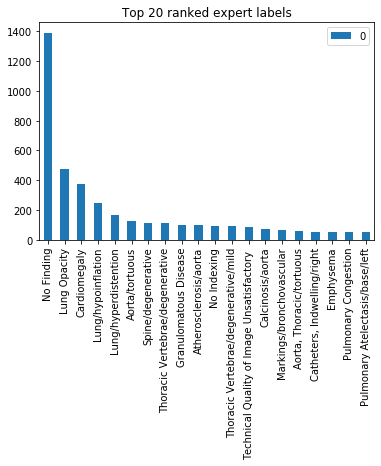

In [18]:
disorder = "Consolidation"
similar_disorders = find_similar_disorders_caseInsensitive(disorder,unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [19]:
create_new_column('Consolidation')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0


## Pneumonia

Pneumonia/lower lobe/right
Pneumonia/upper lobe/right
Pneumonia/lower lobe/left
Pneumonia
Pneumonia/middle lobe/right
Pneumonia/upper lobe/left
Pneumonia/upper lobe/left/round
Pneumonia/base/bilateral/patchy
Pneumonia/right/focal/multiple
Pneumonia/lower lobe/right/mild
Pneumonia/base/left
Pneumonia/lower lobe/right/anterior
Pneumonia/base/bilateral
Pneumonia/focal/multiple
Pneumonia/multilobar
Updating similar labels to : Pneumonia

Total No. of Unique labels: 1487


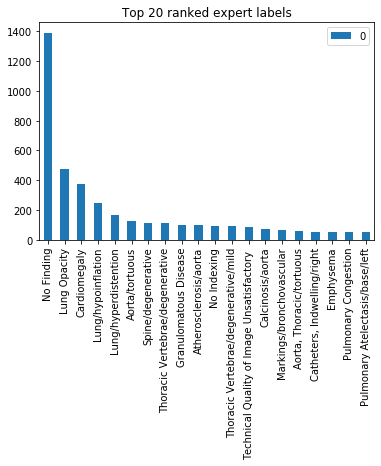

In [20]:
#**********************Pneumonia*********************
disorder = "Pneumonia"
similar_disorders = find_similar_disorders_caseInsensitive(disorder,unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [21]:
create_new_column('Pneumonia')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0


## Atelectasis

Pulmonary Atelectasis/base/left
Pulmonary Atelectasis/base/bilateral
Pulmonary Atelectasis
Pulmonary Atelectasis/base/right
Pulmonary Atelectasis/base/bilateral/mild
Pulmonary Atelectasis/base/left/mild
Pulmonary Atelectasis/lingula
Pulmonary Atelectasis/base/right/mild
Pulmonary Atelectasis/middle lobe/right
Pulmonary Atelectasis/lower lobe/right
Pulmonary Atelectasis/lower lobe/left
Pulmonary Atelectasis/base
Pulmonary Atelectasis/upper lobe/left
Pulmonary Atelectasis/right
Pulmonary Atelectasis/left
Pulmonary Atelectasis/upper lobe/right
Pulmonary Atelectasis/bilateral
Pulmonary Atelectasis/middle lobe/right/mild
Pulmonary Atelectasis/base/bilateral/patchy
Pulmonary Atelectasis/base/left/patchy
Pulmonary Atelectasis/lingula/focal
Pulmonary Atelectasis/focal
Pulmonary Atelectasis/lower lobe/bilateral
Pulmonary Atelectasis/middle lobe/right/focal
Pulmonary Atelectasis/base/mild
Pulmonary Atelectasis/left/severe
Pulmonary Atelectasis/base/left/focal
Pulmonary Atelectasis/base/patchy
Pu

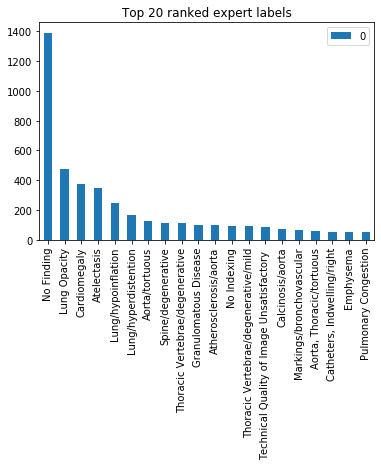

In [22]:
disorder = "Atelectasis"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [23]:
create_new_column('Atelectasis')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0


## Pneumothorax

Pneumothorax/right
Pneumothorax/apex/right/small
Pneumothorax/apex/right/moderate
Pneumothorax/left
Pneumothorax
Pneumothorax/apex/right
Pneumothorax/right/small
Pneumothorax/left/large
Pneumothorax/apex/left/small
Pneumothorax/right/large
Pneumothorax/right/moderate
Pneumothorax/upper lobe/left/small
Pneumothorax/left/moderate
Updating similar labels to : Pneumothorax

Total No. of Unique labels: 1411


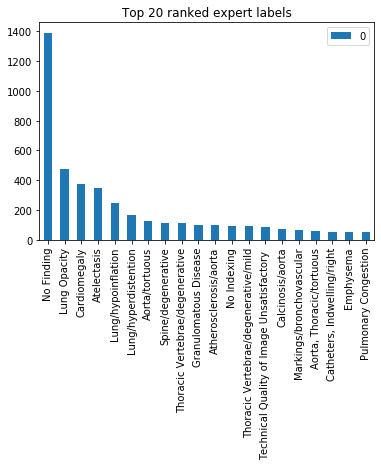

In [24]:
disorder = "Pneumothorax"
similar_disorders = find_similar_disorders_caseSensitive(disorder, unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [25]:
create_new_column('Pneumothorax')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0,0


## Pleural Effusion

Pleural Effusion/bilateral/small
Pleural Effusion/bilateral
Pleural Effusion/left/small
Pleural Effusion/right/small
Pleural Effusion/right
Pleural Effusion/left
Pleural Effusion/right/moderate
Pleural Effusion/left/large
Pleural Effusion/right/large
Pleural Effusion/posterior
Pleural Effusion/left/moderate
Pleural Effusion/base/left
Pleural Effusion/small
Pleural Effusion/base/left/small
Pleural Effusion/bilateral/moderate
Pleural Effusion/base/bilateral
Pleural Effusion/right/focal
Pleural Effusion
Pleural Effusion/bilateral/large
Pleural Effusion/bilateral/posterior/small
Pleural Effusion/right/severe
Pleural Effusion/base/right
Pleural Effusion/hilum/right
Pleural Effusion/costophrenic angle/left
Pleural Effusion/bilateral/posterior/mild
Pleural Effusion/costophrenic angle/left/mild
Pleural Effusion/lower lobe/left
Pleural Effusion/right/focal/multiple
Pleural Effusion/middle lobe/right/small
Pleural Effusion/borderline
Pleural Effusion/upper lobe/right
Pleural Effusion/bilateral/f

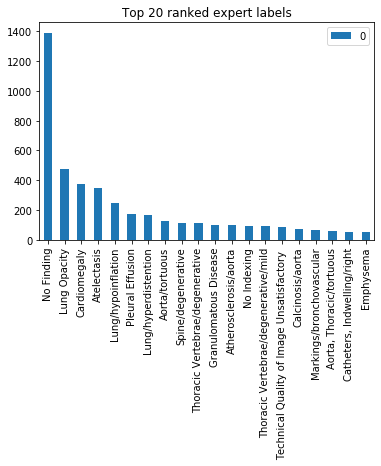

In [26]:
disorder = "Pleural Effusion"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, "Pleural Effusion")
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [27]:
create_new_column('Pleural Effusion')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0,0,0


## Pleural Other

In [28]:
disorder = "Pleural"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
# update_labels(similar_disorders, disorder)
# print()
# unique_labels = plot_Barchart_top_n_labels(20)

Pleural Effusion
Opacity/pleural sinus/bilateral


## Fracture

Fractures, Bone/ribs/left/healed
Fractures, Bone/thoracic vertebrae
Fractures, Bone/ribs/right
Fractures, Bone/ribs/left/multiple/healed
Fractures, Bone/ribs/bilateral/multiple/healed
Fractures, Bone/ribs/right/multiple/healed
Fractures, Bone/ribs/right/healed
Fractures, Bone/sternum
Fractures, Bone/lumbar vertebrae
Fractures, Bone/humerus/right
Fractures, Bone/ribs/healed
Fractures, Bone/clavicle/left/healed
Fractures, Bone/ribs/left/anterior/multiple
Fractures, Bone/clavicle/right
Fractures, Bone/ribs/right/multiple
Fractures, Bone/ribs/left
Fractures, Bone
Fractures, Bone/clavicle/right/healed
Fractures, Bone/ribs/left/chronic
Fractures, Bone/clavicle/right/multiple
Fractures, Bone/Thoracic Vertebrae
Fractures, Bone/ribs/right/anterior/multiple
Fractures, Bone/ribs/right/posterior/healed
Fractures, Bone/ribs/left/multiple
Fractures, Bone/lumbar vertebrae/severe
Fractures, Bone/clavicle/right/mild
Fractures, Bone/ribs/left/posterior/multiple/healed
Fractures, Bone/thoracic vertebrae/

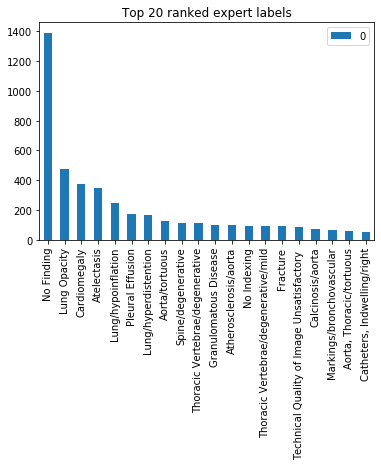

In [29]:
disorder = "Fracture"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, disorder)
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [30]:
create_new_column('Fracture')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Fracture
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0,0,0,0


## Support Devices

Implanted Medical Device/left
Implanted Medical Device
Medical Device
Implanted Medical Device/aortic valve
Implanted Medical Device/right
Implanted Medical Device/heart
Implanted Medical Device/thorax/left
Implanted Medical Device/humerus/right
Medical Device/thorax/left
Medical Device/left
Medical Device/thorax
Implanted Medical Device/pulmonary artery
Implanted Medical Device/cervical vertebrae
Medical Device/spine
Implanted Medical Device/shoulder/right
Implanted Medical Device/heart/right
Implanted Medical Device/mitral valve
Implanted Medical Device/heart atria
Implanted Medical Device/thoracic vertebrae
Medical Device/breast/bilateral
Implanted Medical Device/humerus/left
Medical Device/right
Implanted Medical Device/shoulder/left
Implanted Medical Device/abdomen/right
Updating similar labels to : SupportDevices

Total No. of Unique labels: 1322


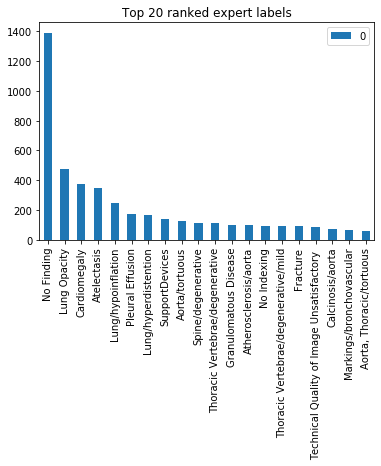

In [31]:
# disorder = "surgical instruments"
disorder = "device"
similar_disorders = find_similar_disorders_caseInsensitive(disorder, unique_labels)
update_labels(similar_disorders, "SupportDevices")
print()
unique_labels = plot_Barchart_top_n_labels(20)

In [32]:
create_new_column('SupportDevices')
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Fracture,SupportDevices
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0,0,0,0,0
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",0,0,0,0,0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0,0,0,0,0


## summery

In [33]:
column_names = ['No Finding','Cardiomegaly','Lung Opacity', 
                'Edema', 'Consolidation', 'Pneumonia', 
                'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 
                'Fracture', 'SupportDevices']

openI_converted = openI_df[column_names].copy()
openI_converted=openI_converted[(openI_converted.T != 0).any()]
total = len(openI_converted)

In [34]:
index_list = openI_converted.index
openI_df = openI_df.iloc[index_list,:]
openI_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,No Finding,Cardiomegaly,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Fracture,SupportDevices
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[No Finding],1,0,0,0,0,0,0,0,0,0,0
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[No Finding],1,0,0,0,0,0,0,0,0,0,0
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[No Finding],1,0,0,0,0,0,0,0,0,0,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[No Finding],1,0,0,0,0,0,0,0,0,0,0
5,1005,NaN,Pruritic.,Cardiac and mediastinal contours are within no...,No acute findings.,[No Finding],1,0,0,0,0,0,0,0,0,0,0


In [35]:
column_names = ['No Finding',"Enlarged Cardiom.",'Cardiomegaly','Lung Lesion','Lung Opacity', 
                'Edema', 'Consolidation', 'Pneumonia', 
                'Atelectasis', 'Pneumothorax', 'Pleural Effusion','Pleural Other', 'Fracture', 'SupportDevices']

def count_percent_pathology(pathology):
    str_count = ""
    count = openI_df[pathology].value_counts()[1]
    str_count = str(count)+" ("+str(round((count/total)*100,2))+ ")"
    return str_count


pretty=PrettyTable()
pretty.field_names = ['Pathology', 'Positive(%)', 'uncertain(%)','Negative(%)']
for pathology in column_names:
    if pathology in ('PleuralEffusion','Enlarged Cardiom.','Lung Lesion','Pleural Other'):
        pretty.add_row([pathology, "-", "-", "-"])
    else:
        pretty.add_row([pathology, count_percent_pathology(pathology), "-", "-"])
print(pretty)

print("Total No. of reports:", total)

+-------------------+--------------+--------------+-------------+
|     Pathology     | Positive(%)  | uncertain(%) | Negative(%) |
+-------------------+--------------+--------------+-------------+
|     No Finding    | 1391 (56.85) |      -       |      -      |
| Enlarged Cardiom. |      -       |      -       |      -      |
|    Cardiomegaly   | 375 (15.32)  |      -       |      -      |
|    Lung Lesion    |      -       |      -       |      -      |
|    Lung Opacity   | 406 (16.59)  |      -       |      -      |
|       Edema       |  46 (1.88)   |      -       |      -      |
|   Consolidation   |  30 (1.23)   |      -       |      -      |
|     Pneumonia     |  42 (1.72)   |      -       |      -      |
|    Atelectasis    | 332 (13.57)  |      -       |      -      |
|    Pneumothorax   |  23 (0.94)   |      -       |      -      |
|  Pleural Effusion |  161 (6.58)  |      -       |      -      |
|   Pleural Other   |      -       |      -       |      -      |
|      Fra

# Export OpenI_with_CheXpert_labels.csv

In [36]:
openI_df.to_csv('data/OpenI/OpenI_cheXpertLabels.csv', index=False)